## Лабораторная работа № 1
### Разведочный анализ данных с помощью PySpark
#### Цель и задачи работы:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом `Apache Spark` и возможностями, которые он предоставляет для обработки больших данных.
3. Получить навыки выполнения разведочного анализа данных использованием `pyspark`.
### Выполните разведочный анализ выбранного датасета с определением: 
* типов признаков в датасете; 
* пропущенных значений и их устранением; 
* выбросов и их устранением; 
* расчетом статистических показателей признаков (средних, квартилей и т.д.); 
* визуализацией распределения наиболее важных признаков; 
* корреляций между признаками.

## Ход работы

#### Создание сессии и загрузка датасета

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *  # col, to_date, udf, count
from pyspark.sql.types import StringType, BooleanType, DateType, IntegerType, DoubleType

from pandas import DataFrame

import matplotlib

import os
import sys
import re

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName('SOBDLab1') \
    .getOrCreate()
csv_file = 'data/proceed.csv'
data = spark.read.csv(csv_file, header=True)
data = data.drop('_c0')
data.printSchema()
data.first()


root
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: string (nullable = true)
 |-- isBasicEconomy: string (nullable = true)
 |-- isRefundable: string (nullable = true)
 |-- isNonStop: string (nullable = true)
 |-- baseFare: string (nullable = true)
 |-- totalFare: string (nullable = true)
 |-- seatsRemaining: string (nullable = true)
 |-- totalTravelDistance: string (nullable = true)



Row(searchDate='2022-01-16', flightDate='2022-01-17', startingAirport='0', destinationAirport='6', fareBasisCode='3718', travelDuration='155', elapsedDays='0', isBasicEconomy='False', isRefundable='False', isNonStop='True', baseFare='222.33', totalFare='253.61', seatsRemaining='1', totalTravelDistance='222')

#### Преобразование типов

In [7]:
data = data.withColumn('searchDate', to_date(data.searchDate, 'yyyy-mm-dd'))
data = data.withColumn('flightDate', to_date(data.flightDate, 'yyyy-mm-dd'))
data = data.withColumn('startingAirport', data.startingAirport.cast(IntegerType()))
data = data.withColumn('destinationAirport', data.destinationAirport.cast(IntegerType()))
data = data.withColumn('fareBasisCode', data.fareBasisCode.cast(IntegerType()))
data = data.withColumn('travelDuration', data.travelDuration.cast(IntegerType()))
data = data.withColumn('elapsedDays', data.elapsedDays.cast(IntegerType()))
data = data.withColumn('isBasicEconomy', data.isBasicEconomy.cast(BooleanType()))
data = data.withColumn('isRefundable', data.isRefundable.cast(BooleanType()))
data = data.withColumn('isNonStop', data.isNonStop.cast(BooleanType()))
data = data.withColumn('baseFare', data.baseFare.cast(DoubleType()))
data = data.withColumn('totalFare', data.totalFare.cast(DoubleType()))
data = data.withColumn('seatsRemaining', data.seatsRemaining.cast(IntegerType()))
data = data.withColumn('totalTravelDistance', data.totalTravelDistance.cast(IntegerType()))

data.printSchema()
data.show()


root
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: integer (nullable = true)
 |-- destinationAirport: integer (nullable = true)
 |-- fareBasisCode: integer (nullable = true)
 |-- travelDuration: integer (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)

+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|t

#### Определение и устранение выбросов

In [8]:
data1 = data
columns = ['travelDuration', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
for column in columns:
    q1, q2, q3 = data.approxQuantile(column, [0.25, 0.5, 0.75], 0)
    print(f'{column}: firstquartile = {q1} median = {q2} lastquartile = {q3}')
    IQR = q3 - q1
    lower_bound = q1 - (1.5 * IQR)
    upper_bound = q3 + (1.5 * IQR)
    data1 = data1.filter(data1[column] > lower_bound)
    data1 = data1.filter(data1[column] < upper_bound)

data1.show()


travelDuration: firstquartile = 257.0 median = 400.0 lastquartile = 554.0
baseFare: firstquartile = 171.16 median = 273.49 lastquartile = 407.44
totalFare: firstquartile = 202.6 median = 313.1 lastquartile = 461.61
seatsRemaining: firstquartile = 5.0 median = 7.0 lastquartile = 9.0
totalTravelDistance: firstquartile = 171.0 median = 273.0 lastquartile = 407.0
+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|2022-01-16|2022-01-17|              0|                 6|    

In [9]:
data_count = data.count()
data1_count = data1.count()
print(data1_count / data_count)


0.9752814552964171


In [5]:
#df = data1.toPandas()
#df.to_csv('data/cleared.csv')

#### Визуализация распределения наиболее важных признаков

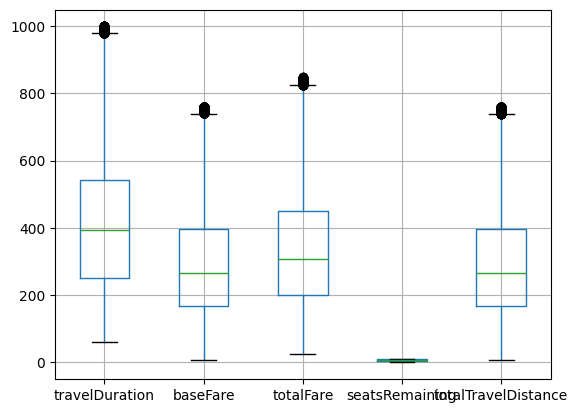

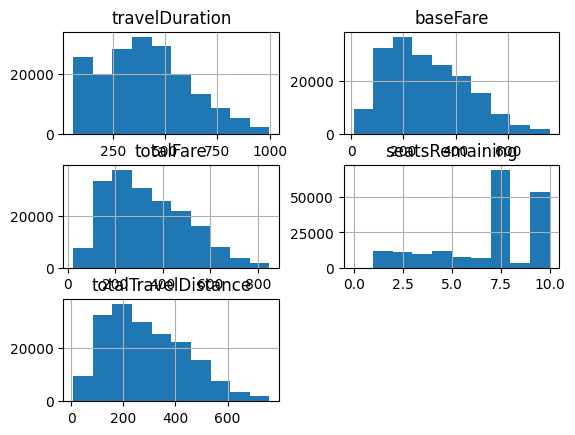

In [10]:
df = data1.toPandas()
boxpl = df.boxplot(column=['travelDuration','baseFare','totalFare','totalTravelDistance'])
histpl = df.hist(column=['travelDuration','baseFare','totalFare','seatsRemaining','totalTravelDistance'])

#### Корреляции между признаками

In [11]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

data1 = data
data1 = data1.drop('searchDate','flightDate')

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data1.columns, outputCol=vector_col)
df_vector = assembler.transform(data1).select(vector_col)

matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = DataFrame(data=corr_matrix, columns = data1.columns, index=data1.columns) 
corr_matrix_df.style.background_gradient(cmap='coolwarm')

,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance
startingAirport,1.000000,-0.079999,-0.031669,0.152313,0.151245,-0.025704,0.000480,-0.064678,0.138944,0.140771,-0.007303,0.138940
destinationAirport,-0.079999,1.000000,-0.011758,0.175914,-0.002701,-0.016318,-0.003733,-0.064977,0.118403,0.119738,-0.003477,0.118393
fareBasisCode,-0.031669,-0.011758,1.000000,-0.048342,0.019567,0.157312,-0.003407,0.065365,-0.222712,-0.221791,0.038020,-0.222713
travelDuration,0.152313,0.175914,-0.048342,1.000000,0.358337,-0.068620,-0.001709,-0.639447,0.439323,0.457810,-0.080679,0.439330
elapsedDays,0.151245,-0.002701,0.019567,0.358337,1.000000,-0.013336,-0.001890,-0.165954,0.152575,0.158989,0.000755,0.152581
isBasicEconomy,-0.025704,-0.016318,0.157312,-0.068620,-0.013336,1.000000,-0.001969,0.027041,-0.370305,-0.367654,0.328255,-0.370280
isRefundable,0.000480,-0.003733,-0.003407,-0.001709,-0.001890,-0.001969,1.000000,-0.002843,0.019477,0.018996,0.005263,0.019482
isNonStop,-0.064678,-0.064977,0.065365,-0.639447,-0.165954,0.027041,-0.002843,1.000000,-0.273783,-0.295165,0.086304,-0.273776
baseFare,0.138944,0.118403,-0.222712,0.439323,0.152575,-0.370305,0.019477,-0.273783,1.000000,0.999658,-0.095119,0.999999
totalFare,0.140771,0.119738,-0.221791,0.457810,0.158989,-0.367654,0.018996,-0.295165,0.999658,1.000000,-0.096640,0.999656
